In [1]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

In [2]:
# loading data
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", delim_whitespace = True, names = names)

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Text(0.5, 1, 'Correlation Matrix')

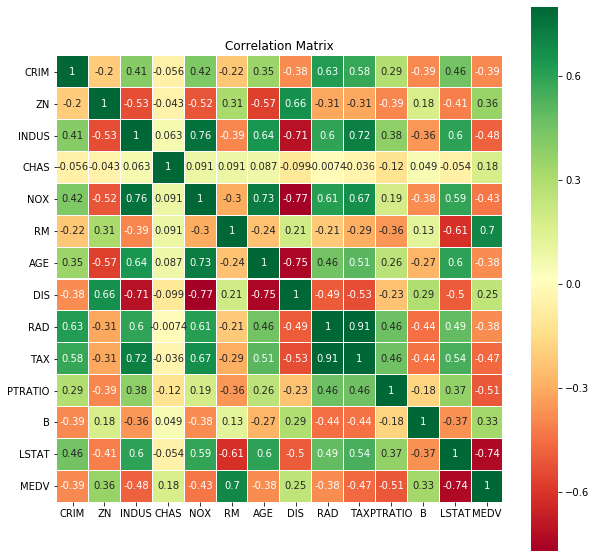

In [4]:
# correlation matrix
pd.set_option('precision', 2)
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'RdYlGn', linecolor = 'white')
plt.title('Correlation Matrix')

It is interesting that the features that correlate the highest with `MEDV` are `RM` (`p = 0.7`) and `LSTAT` (`p = -0.74`). 

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,6.32e-03,18.0,2.31,0,0.54,6.58,65.2,4.09,1,296.0,15.3,396.90,4.98,24.0
1,2.73e-02,0.0,7.07,0,0.47,6.42,78.9,4.97,2,242.0,17.8,396.90,9.14,21.6
2,2.73e-02,0.0,7.07,0,0.47,7.18,61.1,4.97,2,242.0,17.8,392.83,4.03,34.7
3,3.24e-02,0.0,2.18,0,0.46,7.00,45.8,6.06,3,222.0,18.7,394.63,2.94,33.4
4,6.91e-02,0.0,2.18,0,0.46,7.15,54.2,6.06,3,222.0,18.7,396.90,5.33,36.2


In [6]:
y = df['MEDV']
X = df.drop('MEDV', axis = 1)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0,0.54,6.58,65.2,4.09,1,296.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0,0.47,6.42,78.9,4.97,2,242.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0,0.47,7.18,61.1,4.97,2,242.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0,0.46,7.00,45.8,6.06,3,222.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0,0.46,7.15,54.2,6.06,3,222.0,18.7,396.90,5.33


Text(0.5, 1, 'Correlation between Features')

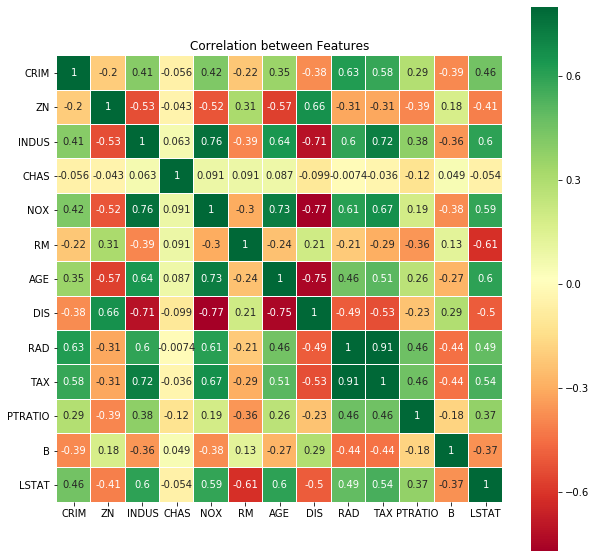

In [7]:
# Correlation matrix of just the features
corr = X.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'RdYlGn', linecolor = 'white')
plt.title('Correlation between Features')

In [8]:
X = df.drop('MEDV', axis = 1)
# drop features that are highly correlated with other features
# matrix of absolute values of correlation
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print(to_drop)

['NOX', 'DIS', 'TAX']


Text(0.5, 1, 'Correlation after dropping Highly Correlated Features')

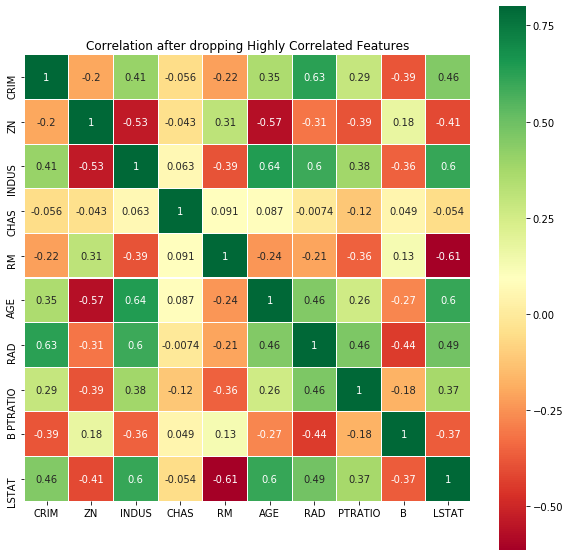

In [9]:
X = df.drop('MEDV', axis = 1)
# Dropping the variables
X.drop(X[to_drop], axis = 1, inplace = True)
# Correlation Matrix after dropping the variables
corr = X.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'RdYlGn', linecolor = 'white')
plt.title('Correlation after dropping Highly Correlated Features')

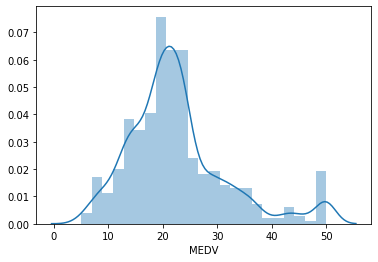

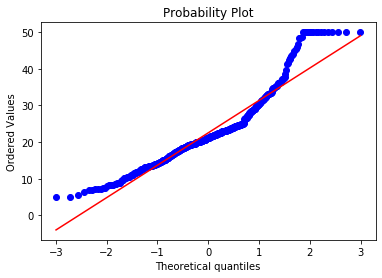

In [10]:
from scipy import stats
# MEDV (median value) is our response variable and the remainders are the predictors
# distribution of MEDV
sns.distplot(df['MEDV'], hist = True)

# histogram and normal probability plot
fig = plt.figure()
res = stats.probplot(df['MEDV'], plot = plt)

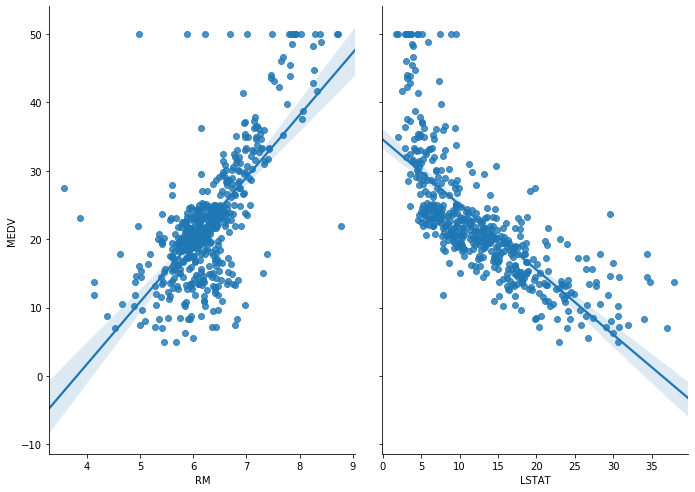

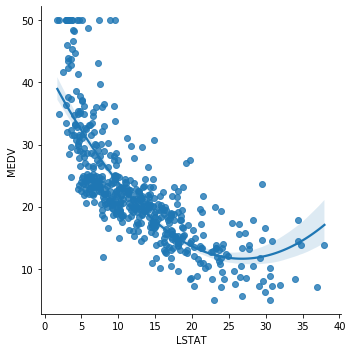

In [11]:
sns.pairplot(df, x_vars = ['RM', 'LSTAT'], y_vars = 'MEDV', kind = 'reg', height = 7, 
            aspect = 0.7)

sns.lmplot(x = "LSTAT", y = "MEDV", data = df, order = 2, truncate = True)

In [41]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# Data Preparataion
# split between training and testing sets, (80/20 split)
X = df[['LSTAT', 'MEDV']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# scaling the data
scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
rescaled_X_test = scaler.transform(X_test)

# function that fits a regression model, prints MSE and R-squared, and returns predictions

def fit_model(regr, X_train, y_train, y_test, rescaled_X_test):
    
    # fit model
    model = regr.fit(X_train, y_train)
    # predictions
    predictions = model.predict(rescaled_X_test)
    # MSE
    print(mean_squared_error(y_test, predictions))
    # R-squared
    print(model.score(X_test, y_test))
    
    return predictions

In [42]:
from sklearn.linear_model import LinearRegression
# Linear Regression Model
regr_LR = LinearRegression()
predictions_LR = fit_model(regr_LR, X_train, y_train, y_test, rescaled_X_test)

701.0559279760138
1.0


In [25]:
from sklearn.ensemble import GradientBoostingRegressor
# Gradient Boosting Regressor
regr_GBR = GradientBoostingRegressor(random_state = 10, n_estimators = 400)
predictions_GBR = fit_model(regr_GBR, X_train, y_train, y_test, rescaled_X_test)

513.0677063860478
0.999490657924816


In [26]:
from sklearn.linear_model import Ridge
# Ridge Regression
regr_Ridge = Ridge(alpha = 0.5, random_state = 10)
fit_model(regr_Ridge, X_train, y_train, y_test, rescaled_X_test)

700.9945479301153
0.9999999992623123


In [28]:
from sklearn.linear_model import Lasso
# Lasso Regression
regr_Lasso = Lasso(alpha = 0.5, random_state = 10)
fit_model(regr_Lasso, X_train, y_train, y_test, rescaled_X_test)

694.2782232738407
0.9999530493318147


In [29]:
from sklearn.tree import DecisionTreeRegressor
# Decision Tree Regression
regr_DT = DecisionTreeRegressor(random_state = 10)
fit_model(regr_DT, X_train, y_train, y_test, rescaled_X_test)

515.4377450980392
0.9991825436152052


In [30]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
# find the best hyperparameters
elastic = ElasticNet(normalize = True)
search = GridSearchCV(estimator = elastic,
                    param_grid = {'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},
                    scoring = 'neg_mean_squared_error',n_jobs = 1,refit = True,cv = 10)
search.fit(X_train, y_train)
search.best_params_

regr_Elastic = ElasticNet(normalize = True, alpha = 0.0001, l1_ratio = 0.2)
fit_model(regr_Elastic, X_train, y_train, y_test, rescaled_X_test)

596.3397117370674
0.9975751954031536


C:\Users\jsteven.raquel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

regr_DT = DecisionTreeRegressor(random_state = 10)
fit_model(regr_DT, X_train, y_train, y_test, rescaled_X_test)

515.4377450980392
0.9991825436152052


In [32]:
# KNN Regression
from sklearn.neighbors import KNeighborsRegressor
regr_KNN = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', algorithm = 'auto')

fit_model(regr_KNN, X_train, y_train, y_test, rescaled_X_test)

226.74423025526607
0.9931603443729561


In [33]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

regr_RF = RandomForestRegressor()

fit_model(regr_RF, X_train, y_train, y_test, rescaled_X_test)

513.0089921568626
0.9994000507601595


C:\Users\jsteven.raquel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:

submissions = pd.DataFrame({
    "Org House Price": y_test,
    "Pred House Price": predictions_LR
})

submissions

,Org House Price,Pred House Price
305,28.4,0.75
193,31.1,1.06
65,23.5,0.19
349,26.6,0.54
151,19.6,-0.26
433,14.3,-0.86
161,50.0,3.21
129,14.3,-0.86
269,20.7,-0.13
226,37.6,1.80
